In [178]:
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dropout, Dense, Activation
from keras.layers.recurrent import LSTM

# Create the Data

In [269]:
n_samples = 50000
omega = 2*np.pi # angular frequency
seq_len = 50 # points per sequence
d_t = .5 # sequence duration
t = np.linspace(0, d_t, seq_len)
X = []
y = []
for i in range(n_samples):
    phi = np.random.rand()*2*np.pi
    X.append(np.sin(t*omega+phi))
    y.append(np.sin((2*t[-1]-t[-2])*omega+phi))
X = np.array(X)
X = X.reshape((X.shape[0], X.shape[1], 1))
y = np.array(y)

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Build the Model

In [271]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

In [272]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, 
    ## in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [282]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

In [273]:
epochs  = 1
#seq_len = 50

print('> Compiling...')

model = build_model([1, 50, 100, 1])

model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.05)

predicted = predict_point_by_point(model, X_test)

> Compiling...


/home/zak/envs/modeling/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/zak/envs/modeling/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True, input_shape=(None, 1))`
/home/zak/envs/modeling/lib/python3.5/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


> Compilation Time :  0.01394033432006836
Train on 33250 samples, validate on 1750 samples
Epoch 1/1
33250/33250 [==============================] - 10s - loss: 0.0395 - val_loss: 0.0050

In [283]:
predicted = predict_sequence_full(model, X_test, seq_len)

In [286]:
len(predicted)

15000

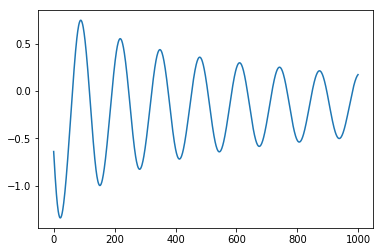

In [289]:
plt.plot(predicted[:1000])

In [287]:
X_test.shape

(15000, 50, 1)

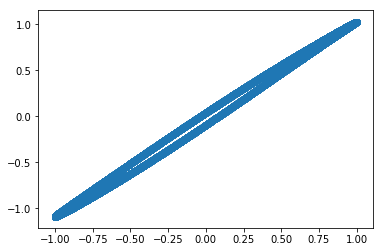

In [274]:
plt.scatter(y_test, predicted)